In [1]:
N = 2
label_dict = {"cats": 0, "dogs": 1}
class_dict = {0: "cats", 1: "dogs"}

In [8]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)


class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        writer.add_scalar("val_loss", val_loss, epoch)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

# 训练模型

In [12]:
train()

data processing...
train...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  3%|##7                                                                                | 1/30 [00:04<02:07,  4.41s/it]

Epoch 000 train_loss 0.67723 val_loss 0.72287


  7%|#####5                                                                             | 2/30 [00:08<02:03,  4.42s/it]

Epoch 001 train_loss 0.63448 val_loss 0.76985


 10%|########3                                                                          | 3/30 [00:13<01:58,  4.39s/it]

Epoch 002 train_loss 0.61610 val_loss 0.62609


 13%|###########                                                                        | 4/30 [00:17<01:54,  4.40s/it]

Epoch 003 train_loss 0.58205 val_loss 0.67005


 17%|#############8                                                                     | 5/30 [00:22<01:49,  4.40s/it]

Epoch 004 train_loss 0.57421 val_loss 0.63643


 20%|################6                                                                  | 6/30 [00:26<01:45,  4.40s/it]

Epoch 005 train_loss 0.55098 val_loss 0.62029


 23%|###################3                                                               | 7/30 [00:30<01:41,  4.40s/it]

Epoch 006 train_loss 0.53628 val_loss 0.62619


 27%|######################1                                                            | 8/30 [00:35<01:37,  4.42s/it]

Epoch 007 train_loss 0.52411 val_loss 0.59414


 30%|########################9                                                          | 9/30 [00:39<01:32,  4.41s/it]

Epoch 008 train_loss 0.52702 val_loss 0.65448


 33%|###########################3                                                      | 10/30 [00:44<01:28,  4.42s/it]

Epoch 009 train_loss 0.53245 val_loss 0.62380


 37%|##############################                                                    | 11/30 [00:48<01:24,  4.43s/it]

Epoch 010 train_loss 0.50837 val_loss 0.69037


 40%|################################8                                                 | 12/30 [00:52<01:19,  4.42s/it]

Epoch 011 train_loss 0.48241 val_loss 0.60223


 43%|###################################5                                              | 13/30 [00:57<01:15,  4.43s/it]

Epoch 012 train_loss 0.48284 val_loss 0.57026


 47%|######################################2                                           | 14/30 [01:01<01:10,  4.42s/it]

Epoch 013 train_loss 0.46663 val_loss 0.58703


 50%|#########################################                                         | 15/30 [01:06<01:06,  4.43s/it]

Epoch 014 train_loss 0.45138 val_loss 0.58958


 53%|###########################################7                                      | 16/30 [01:10<01:01,  4.43s/it]

Epoch 015 train_loss 0.46378 val_loss 0.61024


 57%|##############################################4                                   | 17/30 [01:15<00:57,  4.43s/it]

Epoch 016 train_loss 0.44920 val_loss 0.57342


 60%|#################################################1                                | 18/30 [01:19<00:53,  4.43s/it]

Epoch 017 train_loss 0.43181 val_loss 0.62343


 63%|###################################################9                              | 19/30 [01:24<00:48,  4.44s/it]

Epoch 018 train_loss 0.44405 val_loss 0.60024


 67%|######################################################6                           | 20/30 [01:28<00:44,  4.43s/it]

Epoch 019 train_loss 0.45083 val_loss 0.59633


 70%|#########################################################4                        | 21/30 [01:32<00:39,  4.44s/it]

Epoch 020 train_loss 0.43182 val_loss 0.58815


 73%|############################################################1                     | 22/30 [01:37<00:35,  4.44s/it]

Epoch 021 train_loss 0.43528 val_loss 0.58271


 77%|##############################################################8                   | 23/30 [01:41<00:31,  4.44s/it]

Epoch 022 train_loss 0.42892 val_loss 0.58452


 80%|#################################################################6                | 24/30 [01:46<00:26,  4.43s/it]

Epoch 023 train_loss 0.41755 val_loss 0.59095


 83%|####################################################################3             | 25/30 [01:50<00:22,  4.41s/it]

Epoch 024 train_loss 0.41605 val_loss 0.60280


 87%|#######################################################################           | 26/30 [01:55<00:17,  4.44s/it]

Epoch 025 train_loss 0.41477 val_loss 0.62575


 90%|#########################################################################8        | 27/30 [01:59<00:13,  4.44s/it]

Epoch 026 train_loss 0.42333 val_loss 0.67829


 93%|############################################################################5     | 28/30 [02:03<00:08,  4.43s/it]

Epoch 027 train_loss 0.42530 val_loss 0.63579


 97%|###############################################################################2  | 29/30 [02:08<00:04,  4.42s/it]

Epoch 028 train_loss 0.40071 val_loss 0.60280


100%|##################################################################################| 30/30 [02:12<00:00,  4.42s/it]
2024-11-22 09:20:18.248 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 136.0181806087494 s


Epoch 029 train_loss 0.39772 val_loss 0.59712


# 测试模型预测准确率

In [13]:
test()

data processing...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5396\3471500720.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), 

Accuracy:83%


In [14]:
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms

In [16]:
model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path =r"C:\Users\Administrator\Desktop\新建文件夹\data\testing_data\cats\cat.1074.jpg"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

cats


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5396\2677649406.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), Fa

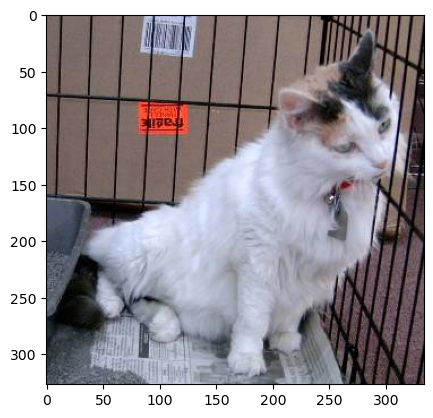

In [17]:
plt.imshow(img, cmap='gray')
plt.show()